<a href="https://colab.research.google.com/github/BlackCat1606/MasterialProject/blob/master/Copy_of_Fitbit_Data_Analysis_Copy1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Integration de google drive et importation de bibliothéques

In [37]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import matplotlib
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt # bibliothéques pour les graphes
import seaborn as sns # pour avoir de meuilleurs graphes visuellement
import datetime
import math

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None) # pour voir toutes les colonnes dans le pd dataframe
%config InlineBackend.figure_format = 'retina' # 

matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12.0, 6.0]

## Importer le Dataset

In [39]:
filename = './gdrive/My Drive/Masterial/data/database_main.xls'

data = pd.read_excel(filename, sheet_name="main", converters= {'Date': pd.to_datetime})
data.set_index(pd.to_datetime(data.Date),inplace=True)

print("Loaded db successfully!")

Loaded db successfully!


## Création de nouvelles colonnes et nettoyage des données
Pour les données de sommeil, nous effacerons les lignes où il n'y avait pas d'entrées "Deep Sleep"

In [0]:
dayCodes = ['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
minDayCodes = ['', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

days = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}

def is_nan(x):
    return (x is np.nan or x != x)

def defineSleepBucket(row):
    sleepEntry = row['Sleep Start time']
    if not is_nan(sleepEntry):
        sleepTimeO = datetime.datetime.strptime(sleepEntry, '%Y-%m-%dT%H:%M:%S.000').time()        
        if sleepTimeO.minute > 30:
            return (sleepTimeO.hour + 1)
            #return '{}:{}'.format(str((sleepTimeO.hour + 1)), '00')
        elif sleepTimeO.minute > 0:
            return sleepTimeO.hour + 0.5
            #return '{}:{}'.format(str(sleepTimeO.hour), ':30')
    else:
        return np.nan
    
def defineAwakeBucket(row):
    awakeEntry = row['Sleep End time']
    if not is_nan(awakeEntry):
        awakeEntryO = datetime.datetime.strptime(awakeEntry, '%Y-%m-%dT%H:%M:%S.000').time()        
        if awakeEntryO.minute > 30:
            return (awakeEntryO.hour + 1)
            #return '{}:{}'.format(str((awakeEntryO.hour + 1)), '00')
        elif awakeEntryO.minute > 0:
            return awakeEntryO.hour + 0.5
            #return '{}:{}'.format(str(awakeEntryO.hour), ':30')
    else:
        return np.nan    

#remove all entries where there was no steps recorded. i.e no activity
data = data[data['Steps'].notnull()]

data['Day Label'] = data['Day of Week'].apply(lambda x: days[x])
data['Active exercise'] = data['Minutes Very Active'] > 40

#Build additional Sleep columns
data['Sleep Bucket'] = data.apply(defineSleepBucket, axis=1)
data['Awake Bucket'] = data.apply(defineAwakeBucket, axis=1)

data['% Awake'] = 100 - (data['% Deep sleep'] + data['% REM sleep'] + data['% Light sleep'])
data['% Restorative sleep'] = data['% Deep sleep'] + data['% REM sleep']
data['Restorative sleep mins'] = data['Minutes Deep sleep'] + data['Minutes REM sleep']

#remove all entries where there was no Deep sleep recorded
sleepData = data[data['% Deep sleep'].notnull()]

In [41]:
print("Contient {} enregistrement entre  {} et {}".format(str(len(data)), str(data.iloc[0]['Date']), str(data.iloc[-1]['Date'])))
print('Contient {} entrées de données de sommeil '.format(len(sleepData)))

sleepData.head()

Contient 116 enregistrement entre  2018-06-24 00:00:00 et 2018-10-17 00:00:00
Contient 76 entrées de données de sommeil 


,Unnamed: 0,Date,Day of Week,Is Weekday,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Sleep Start time,Sleep End time,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep,Day Label,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-24,0,2018-06-24,7,False,True,1996,1690,3367,3.01,0.00,59.0,0,1377,47,2,14,362,-1,11.0,133.10892,14.0,89.20880,0.0,0.0,446.51352,284.0,92.0,379.0,0.0,2018-06-24T22:17:00.000,2018-06-25T05:28:30.000,431.0,56.0,2.0,244.0,26.0,79.0,6.0,52.0,25.0,13.0,57.0,19.0,Sun,False,22.5,5.5,11.0,32.0,135.0
2018-06-25,1,2018-06-25,1,True,False,2863,1685,8394,5.55,36.58,58.0,12,709,244,42,14,1361,-1,2.0,12.40518,94.0,514.11279,0.0,0.0,2311.92765,1326.0,95.0,333.0,0.0,2018-06-25T22:49:30.000,2018-06-26T05:16:30.000,387.0,75.0,3.0,214.0,27.0,44.0,7.0,54.0,30.0,20.0,56.0,12.0,Mon,False,23.0,5.5,12.0,32.0,119.0
2018-06-26,2,2018-06-26,2,True,False,3398,1683,13569,9.68,24.38,57.0,8,687,231,33,102,2004,-1,10.0,103.59112,187.0,1245.54876,0.0,0.0,2034.05724,1232.0,89.0,351.0,0.0,2018-06-26T22:25:30.000,2018-06-27T05:07:30.000,402.0,53.0,3.0,223.0,28.0,75.0,7.0,51.0,29.0,14.0,56.0,19.0,Tue,True,22.5,5.5,11.0,33.0,128.0
2018-06-27,3,2018-06-27,3,True,False,3442,1682,13337,9.33,33.53,57.0,11,665,243,30,100,2035,-1,11.0,114.28908,217.0,1310.46804,0.0,0.0,1986.03570,1187.0,97.0,365.0,0.0,2018-06-27T22:36:30.000,2018-06-28T05:24:00.000,407.0,66.0,4.0,197.0,32.0,102.0,10.0,42.0,32.0,17.0,49.0,26.0,Wed,True,23.0,5.5,8.0,43.0,168.0
2018-07-01,7,2018-07-01,7,False,True,1718,1681,155,0.09,0.00,58.0,0,1427,13,0,0,46,-1,0.0,0.00000,1.0,3.97018,0.0,0.0,233.77354,171.0,96.0,402.0,0.0,2018-07-01T22:34:00.000,2018-07-02T05:54:30.000,440.0,77.0,5.0,233.0,34.0,92.0,8.0,38.0,34.0,18.0,53.0,21.0,Sun,False,23.0,6.0,8.0,39.0,169.0


In [0]:
#data['Active mins > 40'] = data['Minutes Very Active'] > 30
#data.resample('W').mean()

Jetons un rapide coup d'œil sur la façon dont les chiffres se comportent en semaine par rapport aux week-ends

In [43]:
dayGroupedData = data.groupby(['Day of Week']).mean()
dayTypeGroupedData = data.groupby(['Is Weekday']).mean()

dayTypeGroupedData

,Unnamed: 0,Day of Week,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins
Is Weekday,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
False,57.212121,6.515152,1.0,2679.545455,1667.606061,8789.909091,5.716061,33.527879,61.666667,11.000000,943.090909,215.515152,20.181818,26.272727,1222.242424,-1.0,7.037037,54.388412,136.666667,659.956047,0.074074,0.950886,1774.602004,1025.777778,95.380952,376.450000,0.0,414.428571,73.150000,3.400,219.250000,28.900000,84.050000,7.650000,51.900000,28.850000,17.750000,51.750000,19.750000,0.272727,16.452381,7.333333,10.750000,37.500000,157.200000
True,57.614458,2.963855,0.0,2742.457831,1610.048193,8127.807229,5.378795,23.098916,61.121622,7.578313,788.963855,176.734940,26.469880,41.626506,1247.108434,-1.0,8.184211,83.742450,146.105263,785.508394,0.789474,10.055665,1739.526390,1089.631579,95.830508,375.535714,0.0,422.423729,73.660714,3.875,222.732143,30.017857,79.142857,7.767857,53.178571,30.892857,17.678571,52.428571,18.964286,0.457831,20.931034,6.456140,10.928571,36.642857,152.803571


In [44]:
data.groupby(['Day of Week']).mean()

,Unnamed: 0,Is Weekday,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins
Day of Week,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,57.0,1.0,0.0,2766.764706,1679.764706,7474.117647,4.756471,35.142353,61.200000,11.529412,892.235294,197.647059,27.470588,24.470588,1188.058824,-1.0,3.933333,39.324835,147.266667,723.268431,0.000000,0.000000,1884.135575,1165.733333,95.875000,374.200000,0.0,425.812500,68.533333,3.533333,226.200000,29.600000,79.466667,8.133333,52.866667,30.866667,16.466667,53.400000,19.066667,0.117647,23.033333,6.218750,11.066667,35.533333,148.000000
2,58.0,1.0,0.0,2932.000000,1613.529412,9709.941176,6.495294,19.542941,60.625000,6.411765,695.588235,192.470588,31.411765,62.705882,1517.058824,-1.0,9.823529,102.797649,160.176471,917.109046,1.058824,13.772624,1782.886879,1125.058824,94.846154,377.416667,0.0,427.538462,72.666667,3.833333,225.333333,29.750000,79.416667,8.000000,52.833333,31.166667,17.583333,52.750000,19.000000,0.705882,21.192308,6.153846,10.666667,36.583333,152.083333
3,59.0,1.0,0.0,2848.588235,1611.411765,8856.588235,5.938235,22.770000,60.823529,7.470588,749.647059,179.705882,31.176471,51.411765,1370.058824,-1.0,9.117647,90.933628,153.647059,835.312679,0.823529,10.401669,1620.286221,1010.647059,96.769231,371.230769,0.0,419.615385,75.307692,4.153846,217.384615,30.384615,78.538462,6.923077,48.384615,30.769231,18.384615,52.230769,19.153846,0.705882,19.538462,6.083333,10.230769,37.538462,153.846154
4,56.5,1.0,0.0,2695.375000,1604.187500,7546.250000,5.081250,20.955000,61.500000,6.875000,806.750000,166.437500,26.625000,38.187500,1184.937500,-1.0,10.142857,101.458271,150.642857,810.832673,0.571429,6.402520,1711.505051,1085.357143,96.000000,386.363636,0.0,443.636364,83.000000,4.272727,224.454545,31.000000,78.909091,8.181818,57.272727,31.545455,19.181818,51.272727,18.181818,0.437500,21.000000,6.550000,11.363636,37.363636,161.909091
5,57.5,1.0,0.0,2449.562500,1536.687500,6948.562500,4.556875,16.574375,61.666667,5.437500,802.437500,144.937500,15.000000,30.500000,954.562500,-1.0,7.615385,81.592786,111.615385,592.829592,1.538462,20.279408,1702.073737,1063.384615,95.500000,362.400000,0.0,369.500000,66.600000,3.400000,216.200000,28.800000,79.600000,7.400000,58.400000,29.200000,16.400000,51.800000,19.800000,0.312500,18.000000,8.333333,12.000000,36.200000,146.200000
6,58.5,0.0,1.0,2884.000000,1679.500000,10655.500000,6.877500,43.625000,62.076923,14.312500,955.437500,228.187500,26.875000,36.687500,1424.812500,-1.0,6.538462,55.732043,173.769231,903.743161,0.076923,0.951635,1759.771382,994.000000,95.500000,361.100000,0.0,412.500000,66.600000,3.300000,207.700000,28.400000,86.800000,8.000000,51.400000,27.600000,17.100000,51.200000,20.900000,0.437500,10.900000,8.100000,10.800000,38.000000,153.400000
7,56.0,0.0,1.0,2487.117647,1656.411765,7034.058824,4.622941,24.024706,61.285714,7.882353,931.470588,203.588235,13.882353,16.470588,1031.588235,-1.0,7.500000,53.140755,102.214286,433.582299,0.071429,0.950190,1788.373296,1055.285714,95.272727,391.800000,0.0,416.181818,79.700000,3.500000,230.800000,29.400000,81.300000,7.300000,52.400000,30.100000,18.400000,52.300000,18.600000,0.117647,21.500000,6.636364,10.700000,37.000000,161.000000


---
## Utilities

In [0]:
def getDayLabel(dayNum):
    return dayCodes[dayNum]

def plot_heatmap(corrmat, correlationOf, title, darkTheme=False):
    if darkTheme:
        sns.set(style='darkgrid', palette='deep') # Using Seaborn for making heatmap
        cmap="YlGnBu"
    else:     
        sns.set(style = "white")
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corrmat, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    plt.figure(figsize=(10, 10))
    hm = sns.heatmap(corrmat, mask=mask, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, cmap=cmap)
    hm.set_title(title)
    plt.yticks(rotation=0)
    plt.show()

---
# Analyse du sommeil

### 1. Les habitudes de sommeil sont-elles régulières?

 -Le sujet obtient-il les heures de sommeil requises? - Heures de sommeil moyennes et écart.

 -Le sujet suit-il un bon planning de sommeil? - Heures de sommeil et de réveil moyennes

,count,mean,std,min,25%,50%,75%,max
Time in bed,76.0,7.14364,0.821759,3.65,6.895833,7.225,7.454167,9.566667


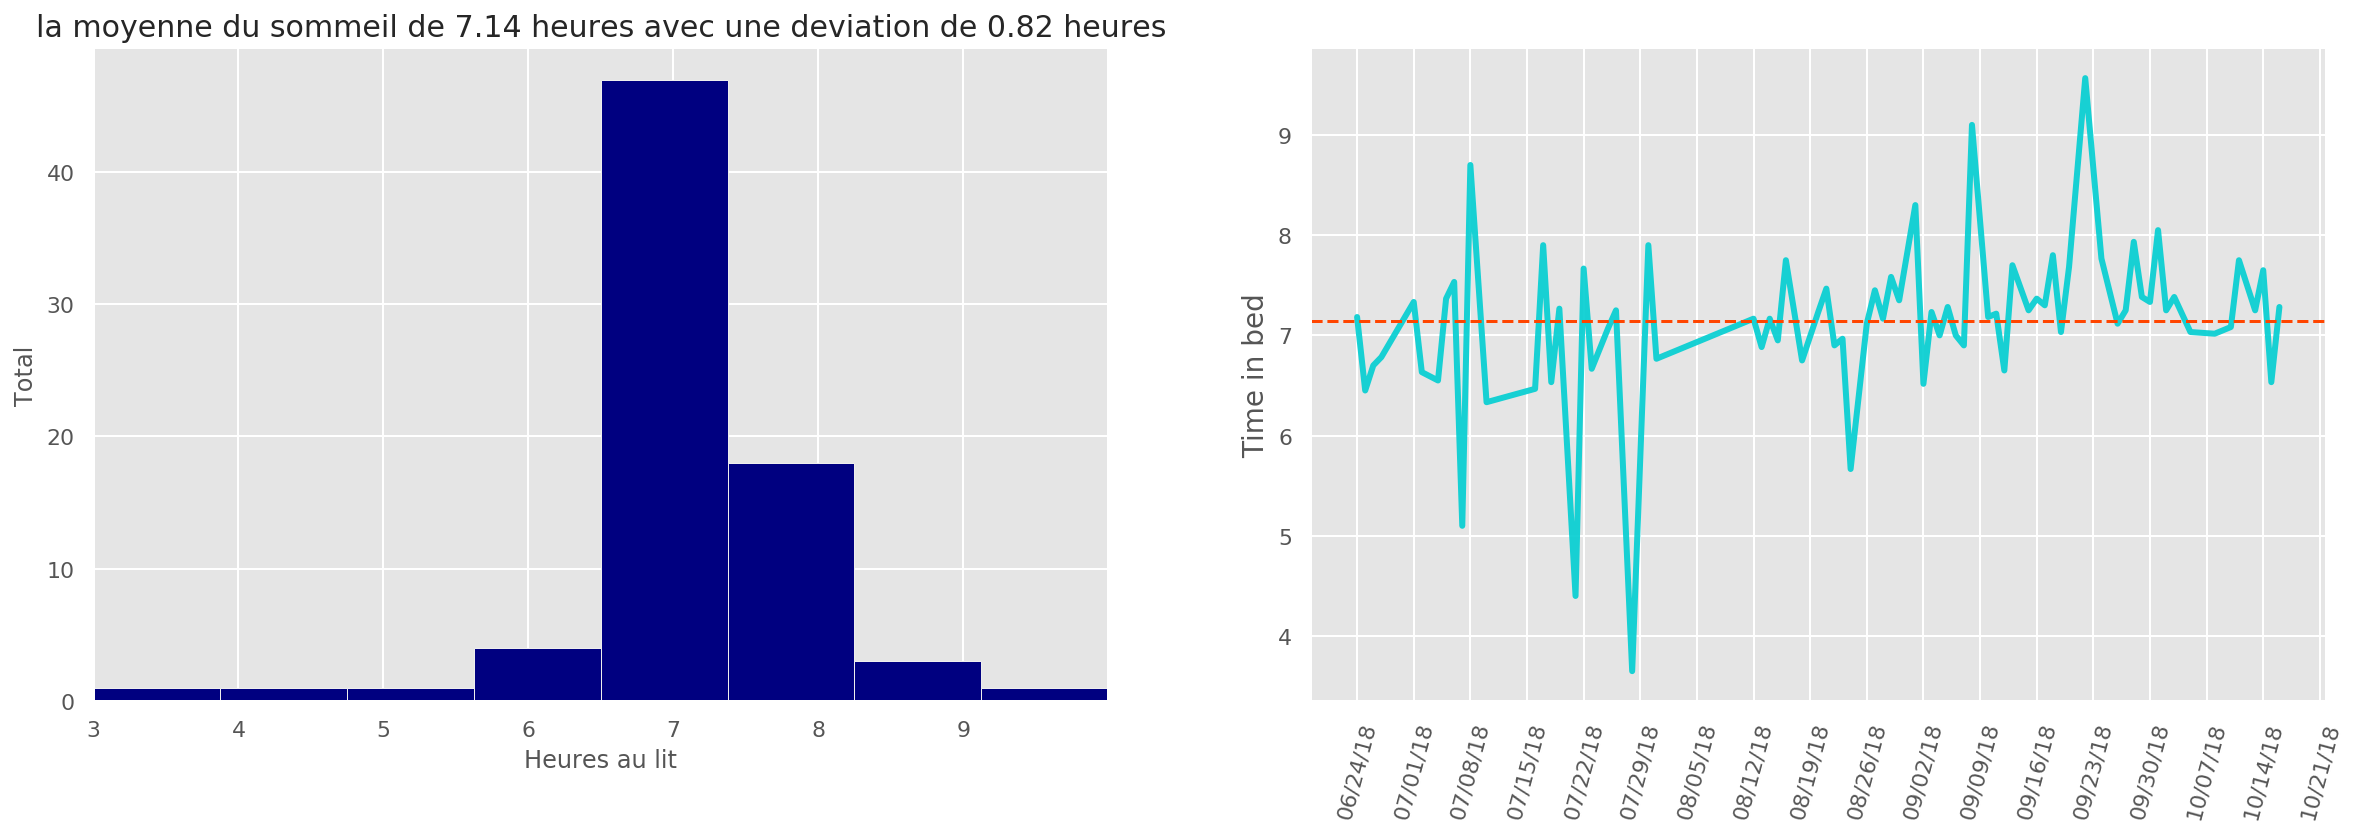

In [46]:
import matplotlib.dates as mdates

sleepDesc = pd.DataFrame(sleepData['Time in bed']/60).describe().transpose()
avgSleepHours = round(sleepDesc.at['Time in bed','mean'],2)
summary = 'la moyenne du sommeil de {} heures avec une deviation de {} heures'.format(avgSleepHours, round(sleepDesc.at['Time in bed','std'],2))
hoursInBed = sleepData['Time in bed']/60

fig = plt.figure(figsize = (20,6))

ax = plt.subplot(121)  
plt.hist(hoursInBed, bins = 8, range = (3, 10), color="navy")
plt.xlim(3, 10)
plt.xticks(range(3, 10))
plt.xlabel('Heures au lit')
plt.ylabel('Total');
plt.title(summary, fontsize=15)

#############

ax2 = fig.add_subplot(122)
plt.plot(sleepData['Date'],hoursInBed, linestyle='-', 
         markersize=10, color='darkturquoise', label='% Light', linewidth=3.0, alpha=0.9)
plt.ylabel('Time in bed', fontsize=14)
ax2.axhline(avgSleepHours, color="orangered", linestyle='--')
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=6))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%D'))
ax2.grid(True)
plt.xticks(rotation=75)
plt.plot()

sleepDesc

En ce qui concerne les données comportementales, elles se comportent raisonnablement bien. Notez que cette distribution ne varie pas beaucoup et est assez raide. L'écart est de moins d'une heure.

D'autre part, selon la [National Sleep Foundation] (https://www.sleepfoundation.org/how-sleep-works/how-much-sleep-do-we-really-need/page/0/2), le sujet devrait dormir entre 7 et 9 heures.

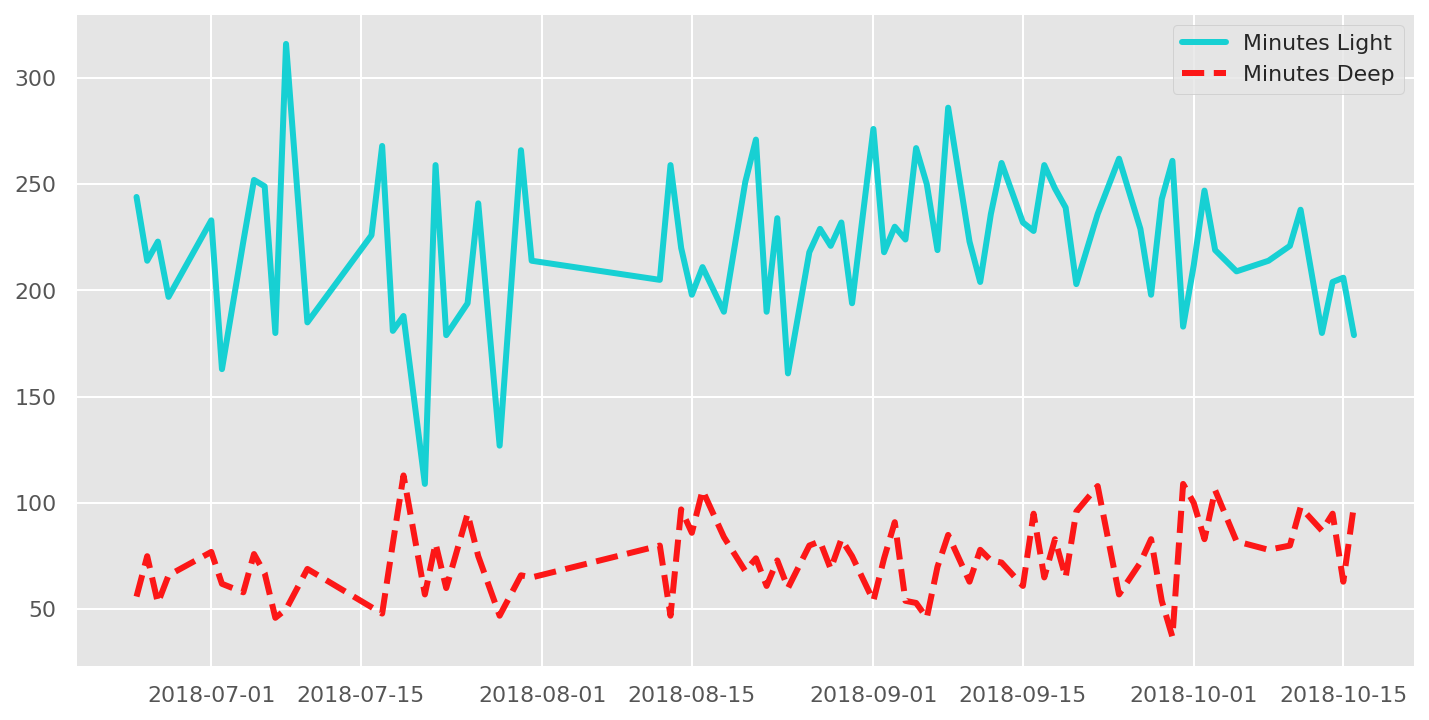

In [47]:
plt.plot(sleepData['Date'],sleepData['Minutes Light sleep'], linestyle='-', 
         markersize=10, color='darkturquoise', label='Minutes Light', linewidth=3.0, alpha=0.9)
plt.plot(sleepData['Date'],sleepData['Minutes Deep sleep'], linestyle='--', 
         markersize=10, color='red', label='Minutes Deep', linewidth=3.0, alpha=0.9)
plt.legend()

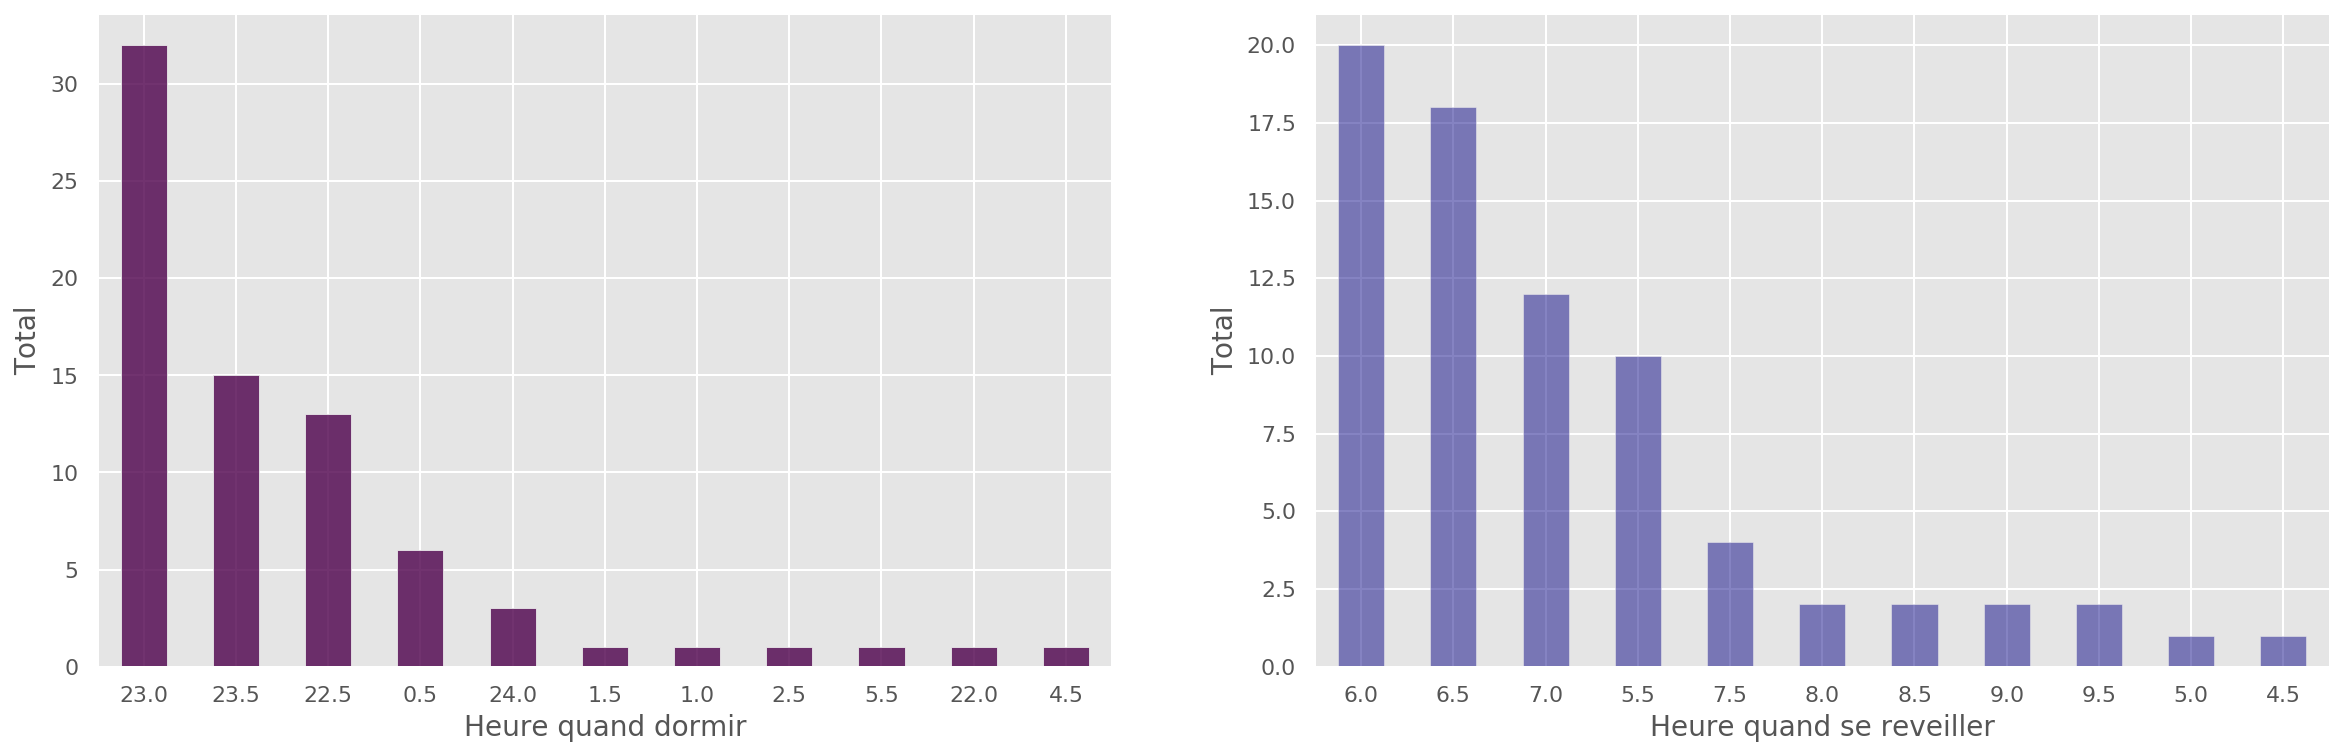

In [48]:
#Tous les jours
sleepBDF = sleepData[['Sleep Bucket', 'Awake Bucket', 'Time in bed']]
sleepBDF['Time in bed'] = sleepBDF['Time in bed']/60

#sleepBDF.groupby(['Sleep Bucket']).mean()
#sleepBDF.describe().transpose()

## plot the sleep and awake counts
fig = plt.figure(figsize = (20,6))

ax = plt.subplot(121)  
pd.value_counts(sleepData['Sleep Bucket']).plot.bar(cmap="BuPu_r", alpha=0.8)
plt.xlabel('Heure quand dormir', fontsize=14)
plt.ylabel('Total', fontsize=14)
plt.xticks(rotation=0)

#############

ax2 = fig.add_subplot(122)
pd.value_counts(sleepData['Awake Bucket']).plot.bar(cmap="plasma", alpha=0.5)
plt.xlabel('Heure quand se reveiller', fontsize=14)
plt.ylabel('Total', fontsize=14)
plt.xticks(rotation=0)
plt.show()

#https://www.sleepfoundation.org/sleep-tools-tips/healthy-sleep-tips

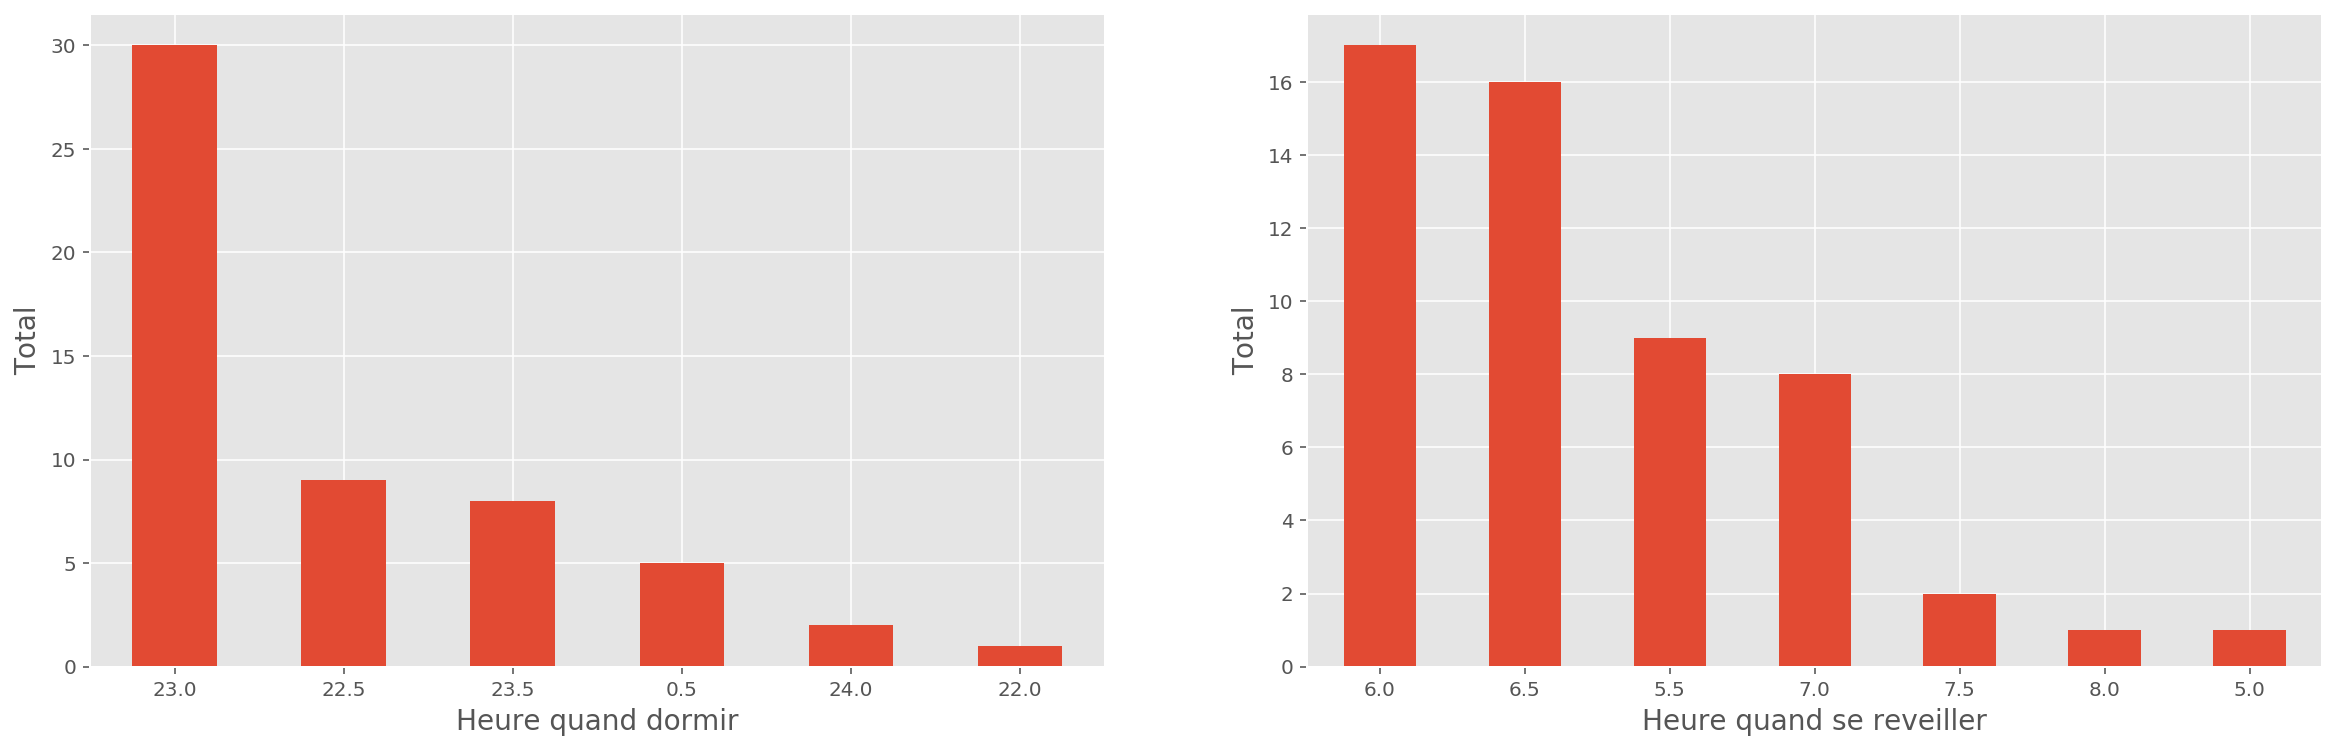

In [13]:
#Jours de semaine

sleepBDF_weekday = sleepData[['Sleep Bucket', 'Awake Bucket', 'Time in bed', 'Is Weekday']]
sleepBDF_weekday['Time in bed'] = sleepBDF_weekday['Time in bed']/60
sleepBDF_weekday = sleepBDF_weekday[sleepBDF_weekday['Is Weekday']]

#sleepBDF.groupby(['Sleep Bucket']).mean()
#sleepBDF.describe().transpose()

## plot the sleep and awake counts
fig = plt.figure(figsize = (20,6))

ax = plt.subplot(121)  
pd.value_counts(sleepBDF_weekday['Sleep Bucket']).plot.bar()
plt.xlabel('Heure quand dormir', fontsize=14)
plt.ylabel('Total', fontsize=14)
plt.xticks(rotation=0)

#############

ax2 = fig.add_subplot(122)
pd.value_counts(sleepBDF_weekday['Awake Bucket']).plot.bar()
plt.xlabel('Heure quand se reveiller', fontsize=14)
plt.ylabel('Total', fontsize=14)
plt.xticks(rotation=0)
plt.show()

#https://www.sleepfoundation.org/sleep-tools-tips/healthy-sleep-tips

## 2. Types de sommeil

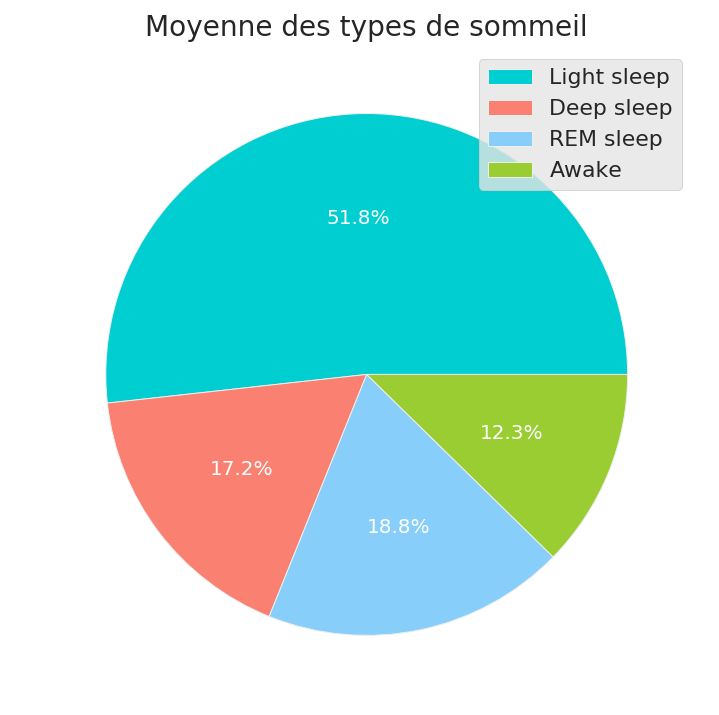

In [49]:
avgSleep = sleepData[['Minutes Light sleep', 'Minutes Deep sleep', 'Minutes REM sleep', 'Minutes Awake']].mean()

fig = plt.figure(figsize = (6,6))
labels=['Light sleep', 'Deep sleep', 'REM sleep', 'Awake']
plt.pie(avgSleep, colors = ['darkturquoise', 'salmon', 'lightskyblue', 'yellowgreen'], autopct='%1.1f%%', labels=labels, textprops=dict(color="w"))

# #carve the donut
# my_circle=plt.Circle( (0,0), 0.7, color='white')
# p=plt.gcf()
# p.gca().add_artist(my_circle)

plt.title('Moyenne des types de sommeil', fontsize=14)
plt.legend()
plt.show()

## 3. Corrélation entre la quantité de sommeil et les phases de sommeil.
Dormir plus vous aidera à atteindre un sommeil plus profond ou REM?

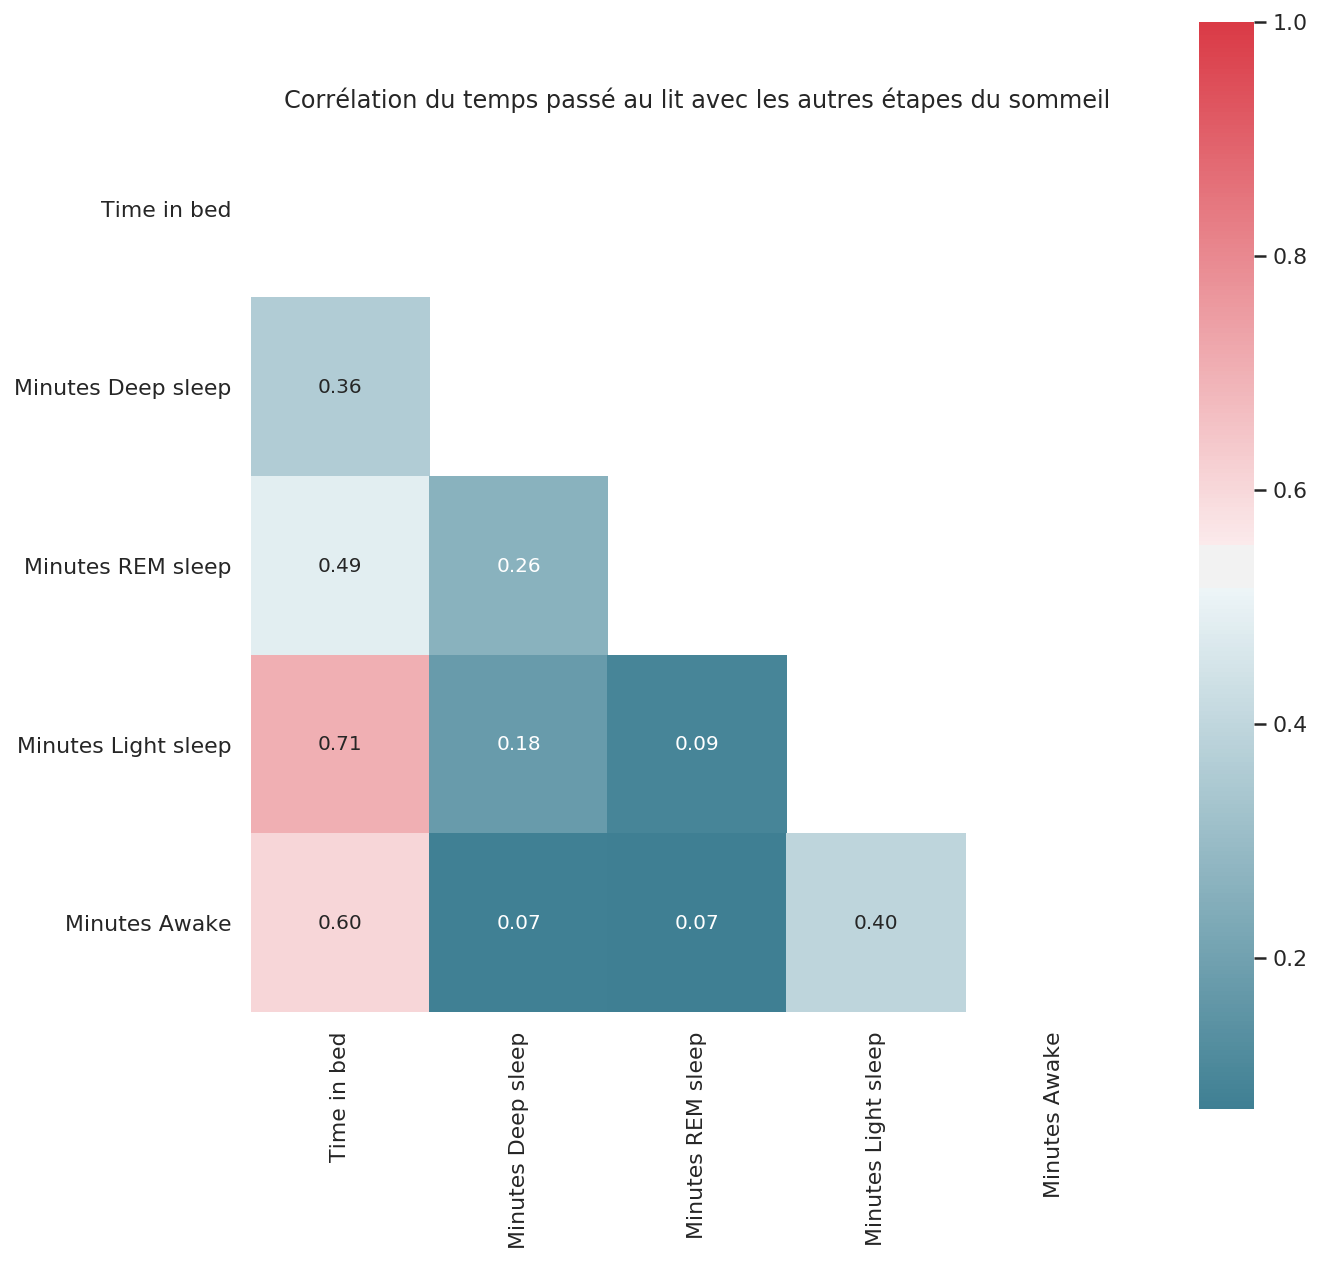

,Time in bed,Minutes Deep sleep,Minutes REM sleep,Minutes Light sleep,Minutes Awake
Time in bed,1.000000,0.363047,0.485731,0.705513,0.604619
Minutes Deep sleep,0.363047,1.000000,0.262515,0.178520,0.074543
Minutes REM sleep,0.485731,0.262515,1.000000,0.092427,0.070540
Minutes Light sleep,0.705513,0.178520,0.092427,1.000000,0.395523
Minutes Awake,0.604619,0.074543,0.070540,0.395523,1.000000


In [50]:
correlationOf = 'Time in Bed'
corrdf_sleep_types = sleepData[['Time in bed', 'Minutes Deep sleep', 'Minutes REM sleep', 'Minutes Light sleep', 'Minutes Awake']].corr().abs()
plot_heatmap(corrdf_sleep_types, correlationOf, 'Corrélation du temps passé au lit avec les autres étapes du sommeil')
corrdf_sleep_types

Notez que les "minutes de sommeil profond" ne sont pas très corrélées avec le temps passé au lit. Ce qui montre que dormir plus ne garantit pas nécessairement un bon sommeil profond.

## 4. Types de sommeil basés sur différents jours

Susceptible d'obtenir un sommeil plus reposant  Saturday


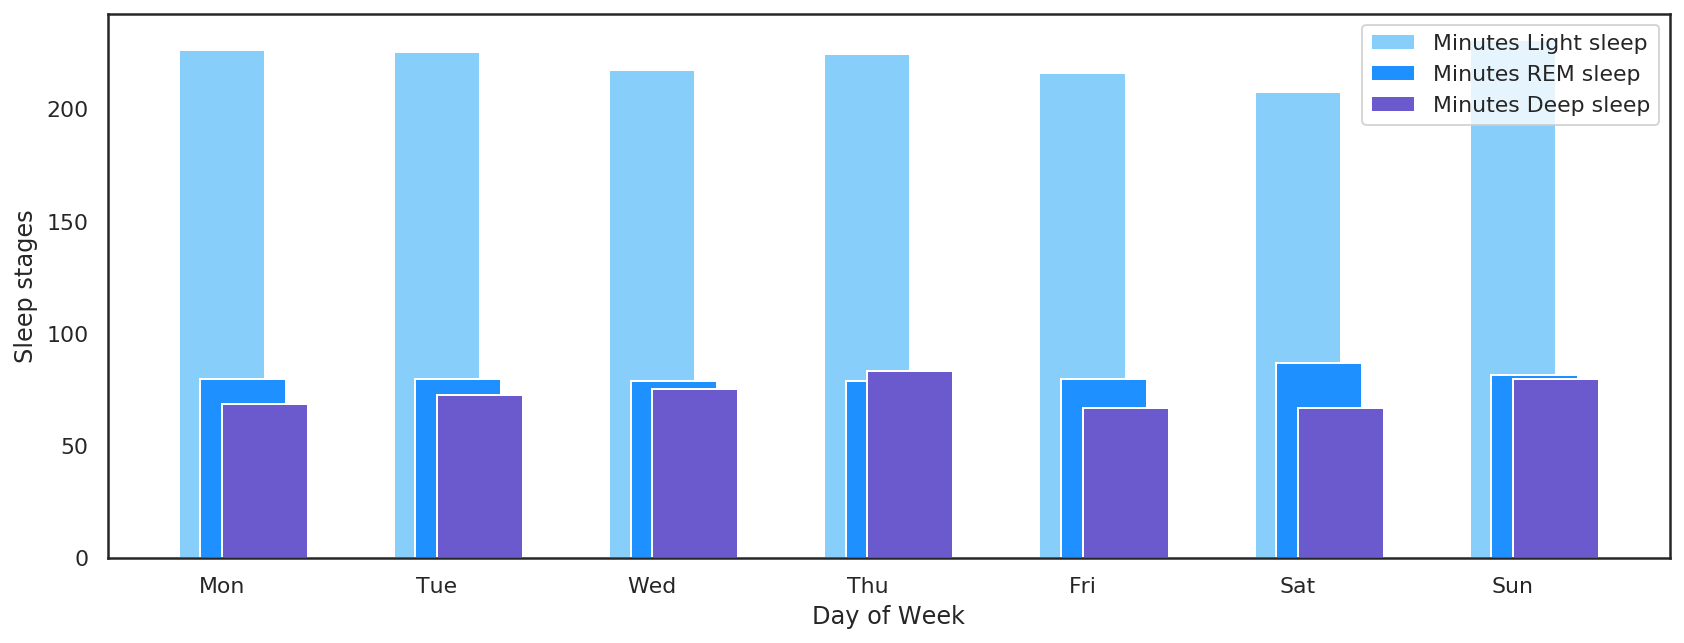

In [51]:
fig = plt.figure(figsize = (14,5))
plt.bar((dayGroupedData.index), dayGroupedData['Minutes Light sleep'],width = 0.4, color='lightskyblue', label="Minutes Light sleep", tick_label=minDayCodes[1:])
plt.bar((dayGroupedData.index + 0.1), dayGroupedData['Minutes REM sleep'], width = 0.4, color='dodgerblue', label="Minutes REM sleep")
plt.bar((dayGroupedData.index + 0.2), dayGroupedData['Minutes Deep sleep'], width = 0.4, color='slateblue', label="Minutes Deep sleep")
plt.xlabel('Day of Week')
plt.ylabel('Sleep stages')
plt.legend()

print("Susceptible d'obtenir un sommeil plus reposant  "+ str(getDayLabel(dayGroupedData['% Restorative sleep'].idxmax())) )

Voyons maintenant les différents jours de la semaine. Le sujet dormait-il plus le week-end? Quelles nuits ont été les pires? 

## Effet du sommeil en semaine vs week-end

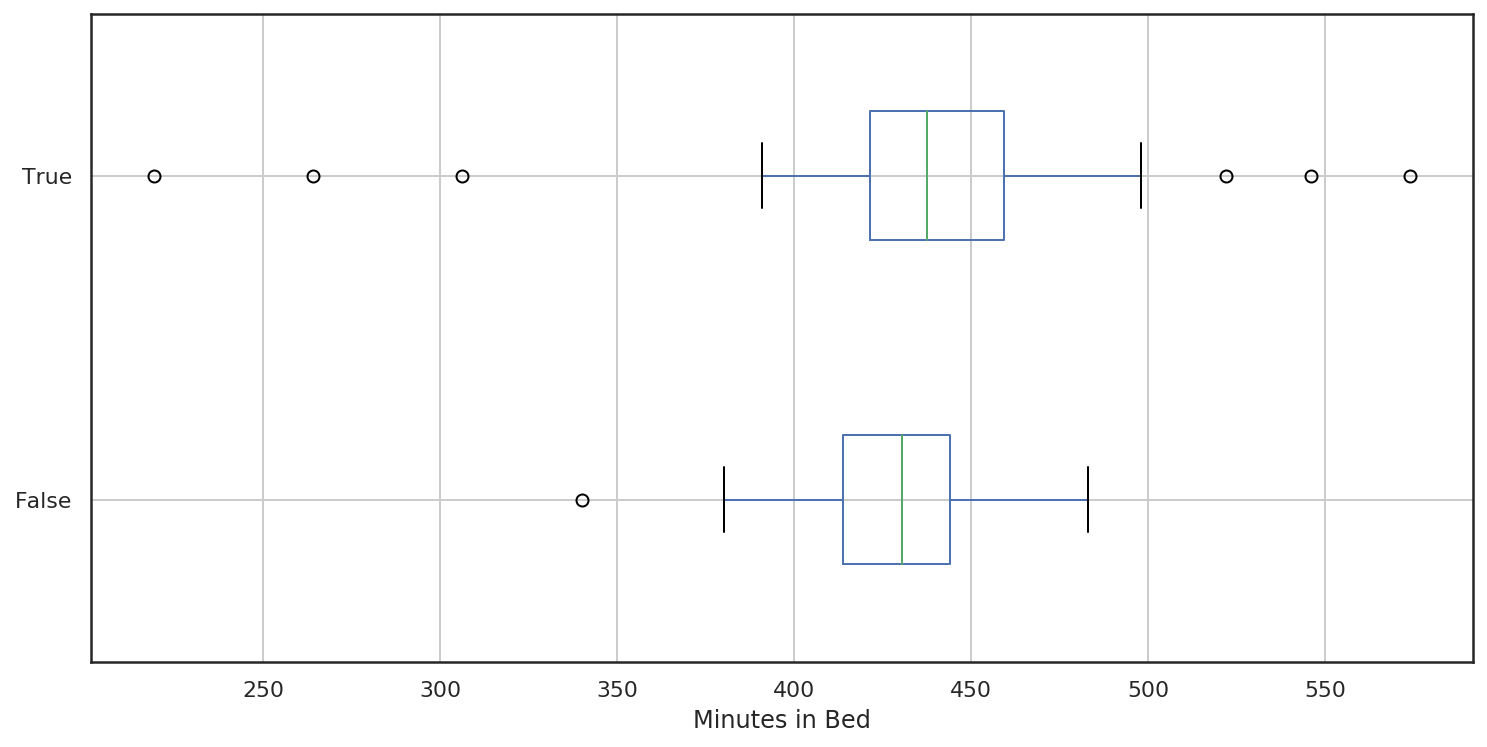

In [52]:
ax = sleepData.boxplot(column = 'Time in bed', by = 'Is Weekend', vert = False, widths = 0.4)
plt.xlabel('Minutes in Bed')
plt.suptitle('')
plt.title('');

L'intrigue ci-dessus montre que le sujet a tendance à dormir un peu plus le week-end. La moustache supérieure est assez élevée pour les week-ends, ce qui indique des heures de sommeil variables.

Voyons comment les graphes varient pour les jours individuels de la semaine.

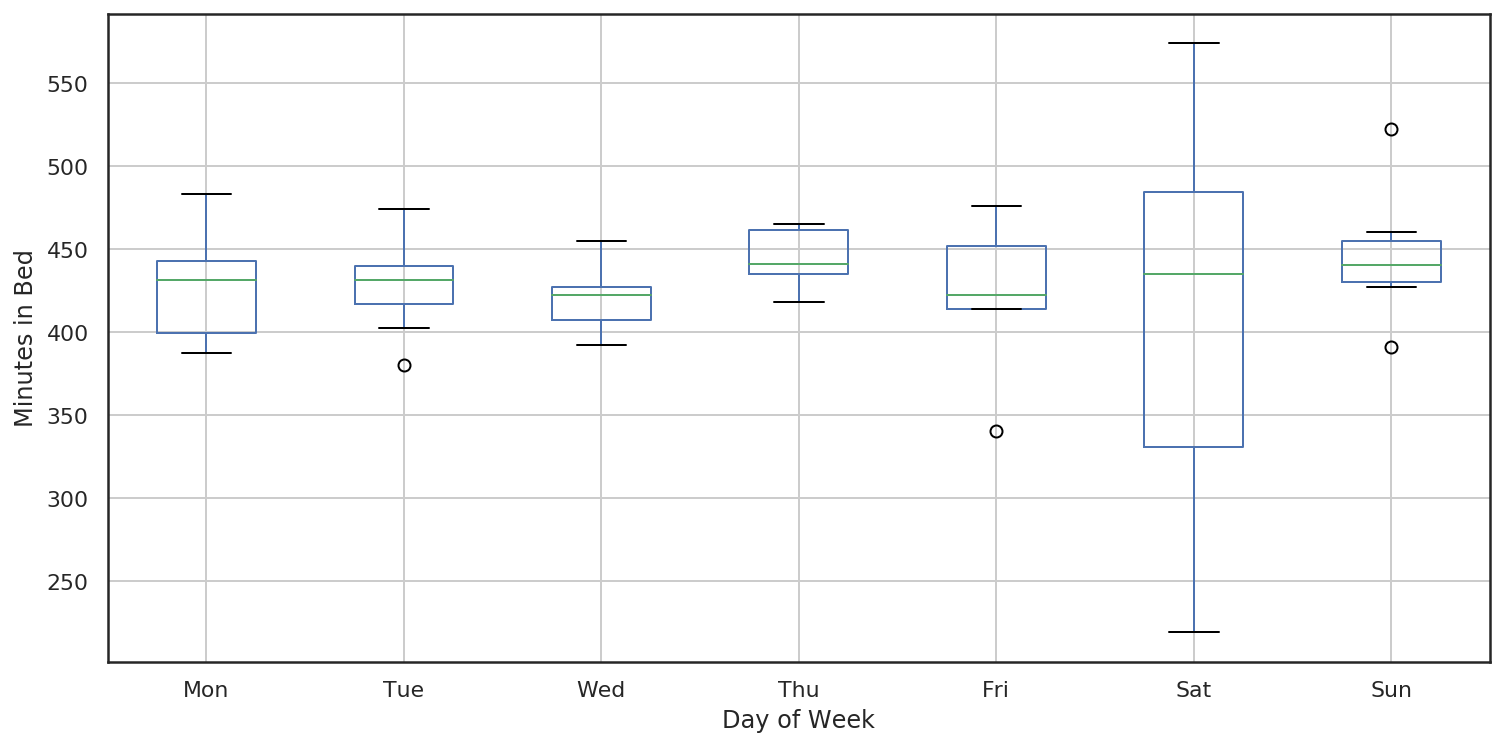

In [53]:
ax = sleepData.boxplot(column = 'Time in bed', by = 'Day of Week')
ax.set_xticklabels(minDayCodes[1:])
plt.ylabel('Minutes in Bed')
plt.suptitle('')
plt.title('');

C'est assez intéressant. Le reste des jours est simple avec des écarts moindres, mais à première vue, le sujet a certainement exploité le sommeil nocturne du samedi!

## Temps de sommeil et de réveil moyens

In [54]:
sleepData['8 > Sleep > 7'] = sleepData['Time in bed'] > 7*60
sleepData['Sleep > 7'] = sleepData['Time in bed'] > 7*60
sleepData['Sleep > 8'] = sleepData['Time in bed'] > 8*60
sleepData['Active mins > 50'] = sleepData['Minutes Very Active'] > 50
sleepData['Active mins > 60'] = sleepData['Minutes Very Active'] > 60

sleepData['wee'] = np.logical_and(sleepData['Sleep Bucket'] <= 23, sleepData['Awake Bucket'] <= 6.5)
# slept before 11 and woke up by 6:30
sleepData

,Unnamed: 0,Date,Day of Week,Is Weekday,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Sleep Start time,Sleep End time,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep,Day Label,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins,8 > Sleep > 7,Sleep > 7,Sleep > 8,Active mins > 50,Active mins > 60,wee
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-24,0,2018-06-24,7,False,True,1996,1690,3367,3.01,0.00,59.0,0,1377,47,2,14,362,-1,11.0,133.10892,14.0,89.20880,0.0,0.0,446.51352,284.0,92.0,379.0,0.0,2018-06-24T22:17:00.000,2018-06-25T05:28:30.000,431.0,56.0,2.0,244.0,26.0,79.0,6.0,52.0,25.0,13.0,57.0,19.0,Sun,False,22.5,5.5,11.0,32.0,135.0,True,True,False,False,False,True
2018-06-25,1,2018-06-25,1,True,False,2863,1685,8394,5.55,36.58,58.0,12,709,244,42,14,1361,-1,2.0,12.40518,94.0,514.11279,0.0,0.0,2311.92765,1326.0,95.0,333.0,0.0,2018-06-25T22:49:30.000,2018-06-26T05:16:30.000,387.0,75.0,3.0,214.0,27.0,44.0,7.0,54.0,30.0,20.0,56.0,12.0,Mon,False,23.0,5.5,12.0,32.0,119.0,False,False,False,False,False,True
2018-06-26,2,2018-06-26,2,True,False,3398,1683,13569,9.68,24.38,57.0,8,687,231,33,102,2004,-1,10.0,103.59112,187.0,1245.54876,0.0,0.0,2034.05724,1232.0,89.0,351.0,0.0,2018-06-26T22:25:30.000,2018-06-27T05:07:30.000,402.0,53.0,3.0,223.0,28.0,75.0,7.0,51.0,29.0,14.0,56.0,19.0,Tue,True,22.5,5.5,11.0,33.0,128.0,False,False,False,True,True,True
2018-06-27,3,2018-06-27,3,True,False,3442,1682,13337,9.33,33.53,57.0,11,665,243,30,100,2035,-1,11.0,114.28908,217.0,1310.46804,0.0,0.0,1986.03570,1187.0,97.0,365.0,0.0,2018-06-27T22:36:30.000,2018-06-28T05:24:00.000,407.0,66.0,4.0,197.0,32.0,102.0,10.0,42.0,32.0,17.0,49.0,26.0,Wed,True,23.0,5.5,8.0,43.0,168.0,False,False,False,True,True,True
2018-07-01,7,2018-07-01,7,False,True,1718,1681,155,0.09,0.00,58.0,0,1427,13,0,0,46,-1,0.0,0.00000,1.0,3.97018,0.0,0.0,233.77354,171.0,96.0,402.0,0.0,2018-07-01T22:34:00.000,2018-07-02T05:54:30.000,440.0,77.0,5.0,233.0,34.0,92.0,8.0,38.0,34.0,18.0,53.0,21.0,Sun,False,23.0,6.0,8.0,39.0,169.0,True,True,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-11,109,2018-10-11,4,True,False,3034,1675,10386,6.54,27.43,64.0,9,686,269,19,41,1581,-1,2.0,20.24316,207.0,1043.22078,0.0,0.0,1902.97338,1177.0,93.0,402.0,0.0,2018-10-11T22:08:30.000,2018-10-12T05:53:30.000,465.0,98.0,4.0,238.0,30.0,66.0,8.0,63.0,31.0,22.0,52.0,15.0,Thu,True,22.5,6.0,11.0,37.0,164.0,True,True,False,False,False,True
2018-10-13,111,2018-10-13,6,False,True,2304,1675,6304,4.08,27.43,64.0,9,840,181,0,0,792,-1,0.0,0.00000,62.0,328.42782,0.0,0.0,1598.16258,1057.0,98.0,396.0,0.0,2018-10-13T23:30:00.000,2018-10-14T06:45:30.000,435.0,87.0,3.0,180.0,27.0,129.0,14.0,39.0,29.0,20.0,42.0,30.0,Sat,False,23.5,7.0,8.0,50.0,216.0,True,True,False,False,False,False
2018-10-14,112,2018-10-14,7,False,True,3008,1675,11779,7.55,6.10,62.0,2,667,245,30,63,1639,-1,3.0,28.38696,151.0,940.72524,0.0,0.0,2011.51860,1267.0,97.0,403.0,0.0,2018-10-14T22:16:30.000,2018-10-15T05:55:30.000,459.0,95.0,4.0,204.0,25.0,104.0,8.0,56.0,28.0,21.0,45.0,23.0,Sun,True,22.5,6.0,11.0,44.0,199.0,True,True,False,True,True,True


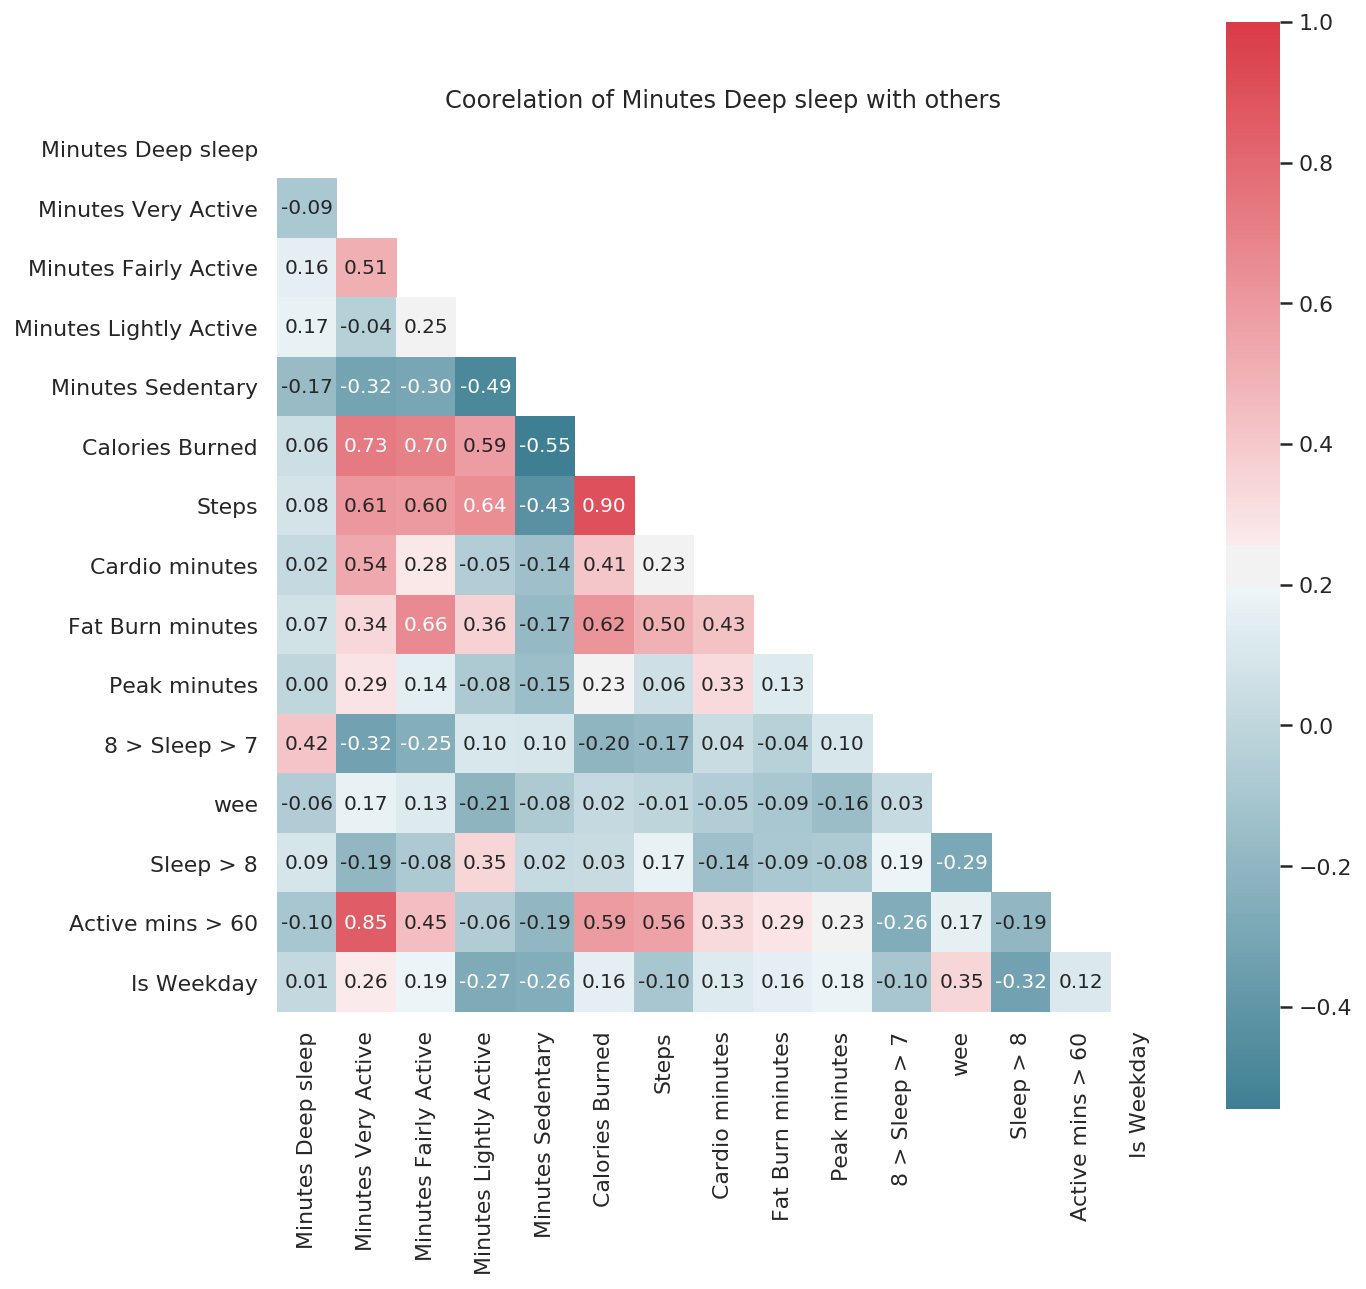

In [55]:
correlationOf="Minutes Deep sleep"
k = 15 #number of variables for heatmap
corrmat = sleepData[['Minutes Deep sleep', 'Minutes Very Active', 'Minutes Fairly Active', 'Minutes Lightly Active', 'Minutes Sedentary', 'Calories Burned', 'Steps',
          'Cardio minutes', 'Fat Burn minutes', 'Peak minutes',
          '8 > Sleep > 7', 'wee', 'Sleep > 8', 'Active mins > 60', 'Is Weekday']].corr()
#corrmat = sleepData.drop(['% Restorative sleep', 'Minutes Light sleep', 'Minutes REM sleep', '% Deep sleep', '% Light sleep', '% REM sleep', 'REM sleep count', 'Deep sleep count', 'Light sleep count'], axis=1).corr().abs()
#cols = corrmat.nlargest(k, correlationOf)[correlationOf].index
#corrdf_sleep = sleepData[cols]

plot_heatmap(corrmat, correlationOf, 'Coorelation of {} with others'.format(correlationOf), darkTheme=False)

## Machine Learning

Puisque nous avons maintenant quelques informations sur les données de sommeil. Voyons voir si nous pourrions utiliser certaines des techniques de base de ML pour voir s'il existe un modèle pour prédire quels sont les ingrédients d'un sommeil décent!

Bien que nous ayons une poignée de données et beaucoup moins de fonctionnalités, voyons ce que nous pouvons prédire.

In [56]:
sleepData.head()

,Unnamed: 0,Date,Day of Week,Is Weekday,Is Weekend,Calories Burned,Calories BMR,Steps,Distance (Km),Elevation (Ft),Resting Heart Rate,Floors,Minutes Sedentary,Minutes Lightly Active,Minutes Fairly Active,Minutes Very Active,Activity Calories,Active Score,Cardio minutes,Cardio calories,Fat Burn minutes,Fat Burn calories,Peak minutes,Peak calories,Normal Cardio calories,Normal Cardio minutes,Sleep Efficiency,Minutes Asleep,Minutes to fall asleep,Sleep Start time,Sleep End time,Time in bed,Minutes Deep sleep,Deep sleep count,Minutes Light sleep,Light sleep count,Minutes REM sleep,REM sleep count,Minutes Awake,Minutes Awake count,% Deep sleep,% Light sleep,% REM sleep,Day Label,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins,8 > Sleep > 7,Sleep > 7,Sleep > 8,Active mins > 50,Active mins > 60,wee
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-06-24,0,2018-06-24,7,False,True,1996,1690,3367,3.01,0.00,59.0,0,1377,47,2,14,362,-1,11.0,133.10892,14.0,89.20880,0.0,0.0,446.51352,284.0,92.0,379.0,0.0,2018-06-24T22:17:00.000,2018-06-25T05:28:30.000,431.0,56.0,2.0,244.0,26.0,79.0,6.0,52.0,25.0,13.0,57.0,19.0,Sun,False,22.5,5.5,11.0,32.0,135.0,True,True,False,False,False,True
2018-06-25,1,2018-06-25,1,True,False,2863,1685,8394,5.55,36.58,58.0,12,709,244,42,14,1361,-1,2.0,12.40518,94.0,514.11279,0.0,0.0,2311.92765,1326.0,95.0,333.0,0.0,2018-06-25T22:49:30.000,2018-06-26T05:16:30.000,387.0,75.0,3.0,214.0,27.0,44.0,7.0,54.0,30.0,20.0,56.0,12.0,Mon,False,23.0,5.5,12.0,32.0,119.0,False,False,False,False,False,True
2018-06-26,2,2018-06-26,2,True,False,3398,1683,13569,9.68,24.38,57.0,8,687,231,33,102,2004,-1,10.0,103.59112,187.0,1245.54876,0.0,0.0,2034.05724,1232.0,89.0,351.0,0.0,2018-06-26T22:25:30.000,2018-06-27T05:07:30.000,402.0,53.0,3.0,223.0,28.0,75.0,7.0,51.0,29.0,14.0,56.0,19.0,Tue,True,22.5,5.5,11.0,33.0,128.0,False,False,False,True,True,True
2018-06-27,3,2018-06-27,3,True,False,3442,1682,13337,9.33,33.53,57.0,11,665,243,30,100,2035,-1,11.0,114.28908,217.0,1310.46804,0.0,0.0,1986.03570,1187.0,97.0,365.0,0.0,2018-06-27T22:36:30.000,2018-06-28T05:24:00.000,407.0,66.0,4.0,197.0,32.0,102.0,10.0,42.0,32.0,17.0,49.0,26.0,Wed,True,23.0,5.5,8.0,43.0,168.0,False,False,False,True,True,True
2018-07-01,7,2018-07-01,7,False,True,1718,1681,155,0.09,0.00,58.0,0,1427,13,0,0,46,-1,0.0,0.00000,1.0,3.97018,0.0,0.0,233.77354,171.0,96.0,402.0,0.0,2018-07-01T22:34:00.000,2018-07-02T05:54:30.000,440.0,77.0,5.0,233.0,34.0,92.0,8.0,38.0,34.0,18.0,53.0,21.0,Sun,False,23.0,6.0,8.0,39.0,169.0,True,True,False,False,False,True


## Regression

In [0]:
from sklearn.model_selection import train_test_split

Construisons notre ensemble de données d'entrainement et de test

In [58]:
y = sleepData['Restorative sleep mins']
X = sleepData[['Day of Week', 'Minutes Sedentary', 'Minutes Lightly Active','Time in bed']]
X.fillna(X.mean(), inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print('X shape: {}'.format(X.shape))
print('Y shape: {}'.format(y.shape))

X shape: (76, 4)
Y shape: (76,)


### Linear Regression

In [59]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
lr_y_pred = regr.predict(X_test)
                        
print("Mean squared error: %.2f"% mean_squared_error(y_test, lr_y_pred))
coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(regr.coef_))], axis = 1)
coefficients

Mean squared error: 1021.75


,0,0
0,Day of Week,1.666643
1,Minutes Sedentary,0.014496
2,Minutes Lightly Active,-0.050772
3,Time in bed,0.358007


### XGboost

In [71]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV

xgbR = XGBRegressor()
parameters = {'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [3, 4, 5, 6],
              'min_child_weight': [1, 5, 10],
              'silent': [1],
              'n_estimators': [500],
              'seed': [1212]
             }

xgb_grid = GridSearchCV(xgbR, parameters, n_jobs = 5, verbose=True)
xgb_grid.fit(X_train, y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

y_pred = xgb_grid.predict(X_test)
rmse = mean_squared_error(y_test,y_pred)
print("RMSE: %f" % (rmse))

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    1.7s


-0.7268760079363294
{'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 500, 'objective': 'reg:linear', 'seed': 1212, 'silent': 1}
RMSE: 0.258418


[Parallel(n_jobs=5)]: Done 180 out of 180 | elapsed:    6.8s finished


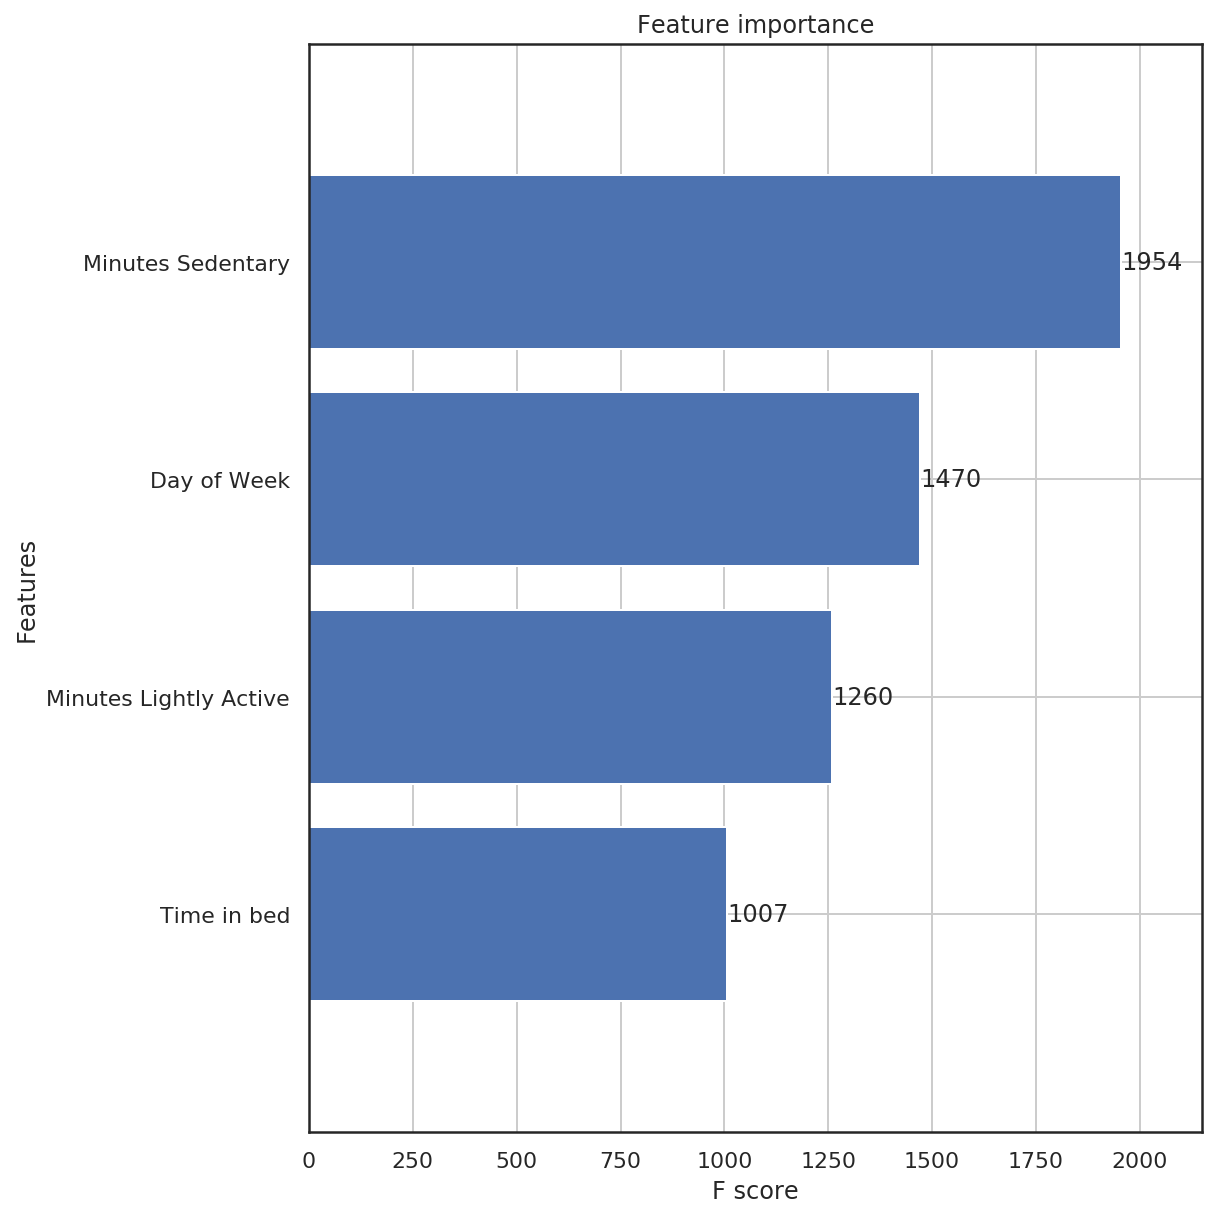

In [65]:
fig, ax = plt.subplots(figsize=(8,10))
xgb.plot_importance(xgb_grid.best_estimator_, height=0.8, ax=ax)
plt.show()
#y_pred = xgb_grid.predict(X_test)

### Classification

In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import graphviz 



def trainAndPredict(classifier):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    
    print ("Accuracy : ",accuracy_score(y_test,y_pred)*100)
    print("Report : ",classification_report(y_test, y_pred))
    #print("Confusion Matrix: ",confusion_matrix(y_test, y_pred))
    return

def plotGraph(classifier):
    dot_data = tree.export_graphviz(classifier, out_file=None, 
                         feature_names=X.columns.values,  
                         class_names=['Yes', 'No'],                                
                         filled=True, rounded=True,  
                         special_characters=True)  
    graph = graphviz.Source(dot_data)  
    return graph

In [67]:
Y = sleepData['% Restorative sleep'] > 35

print('X shape: {}'.format(X.shape))
print('Y shape: {}'.format(Y.shape))

X_train, X_test, y_train, y_test = train_test_split( X, Y, test_size = 0.3, random_state = 100)
print('X_train shape: {}. X_test shape: {}'.format(X_train.shape, X_test.shape))

X shape: (76, 4)
Y shape: (76,)
X_train shape: (53, 4). X_test shape: (23, 4)


L'indice Gini considère une division binaire pour chaque attribut. Vous pouvez calculer une somme pondérée de l'impureté de chaque partition. Si une division binaire sur l'attribut A partitionne les données D en D1 et D2, l'indice de Gini de D.

Dans le cas d'un attribut à valeur discrète, le sous-ensemble qui donne l'index gini minimum pour celui choisi est sélectionné comme attribut de fractionnement. Dans le cas d'attributs à valeur continue, la stratégie consiste à sélectionner chaque paire de valeurs adjacentes comme point de partage possible et point avec un indice de Gini plus petit choisi comme point de partage.

L'attribut avec un indice de Gini minimum est choisi comme attribut de fractionnement.

Accuracy :  39.130434782608695
Report :                precision    recall  f1-score   support

       False       0.42      0.42      0.42        12
        True       0.36      0.36      0.36        11

    accuracy                           0.39        23
   macro avg       0.39      0.39      0.39        23
weighted avg       0.39      0.39      0.39        23



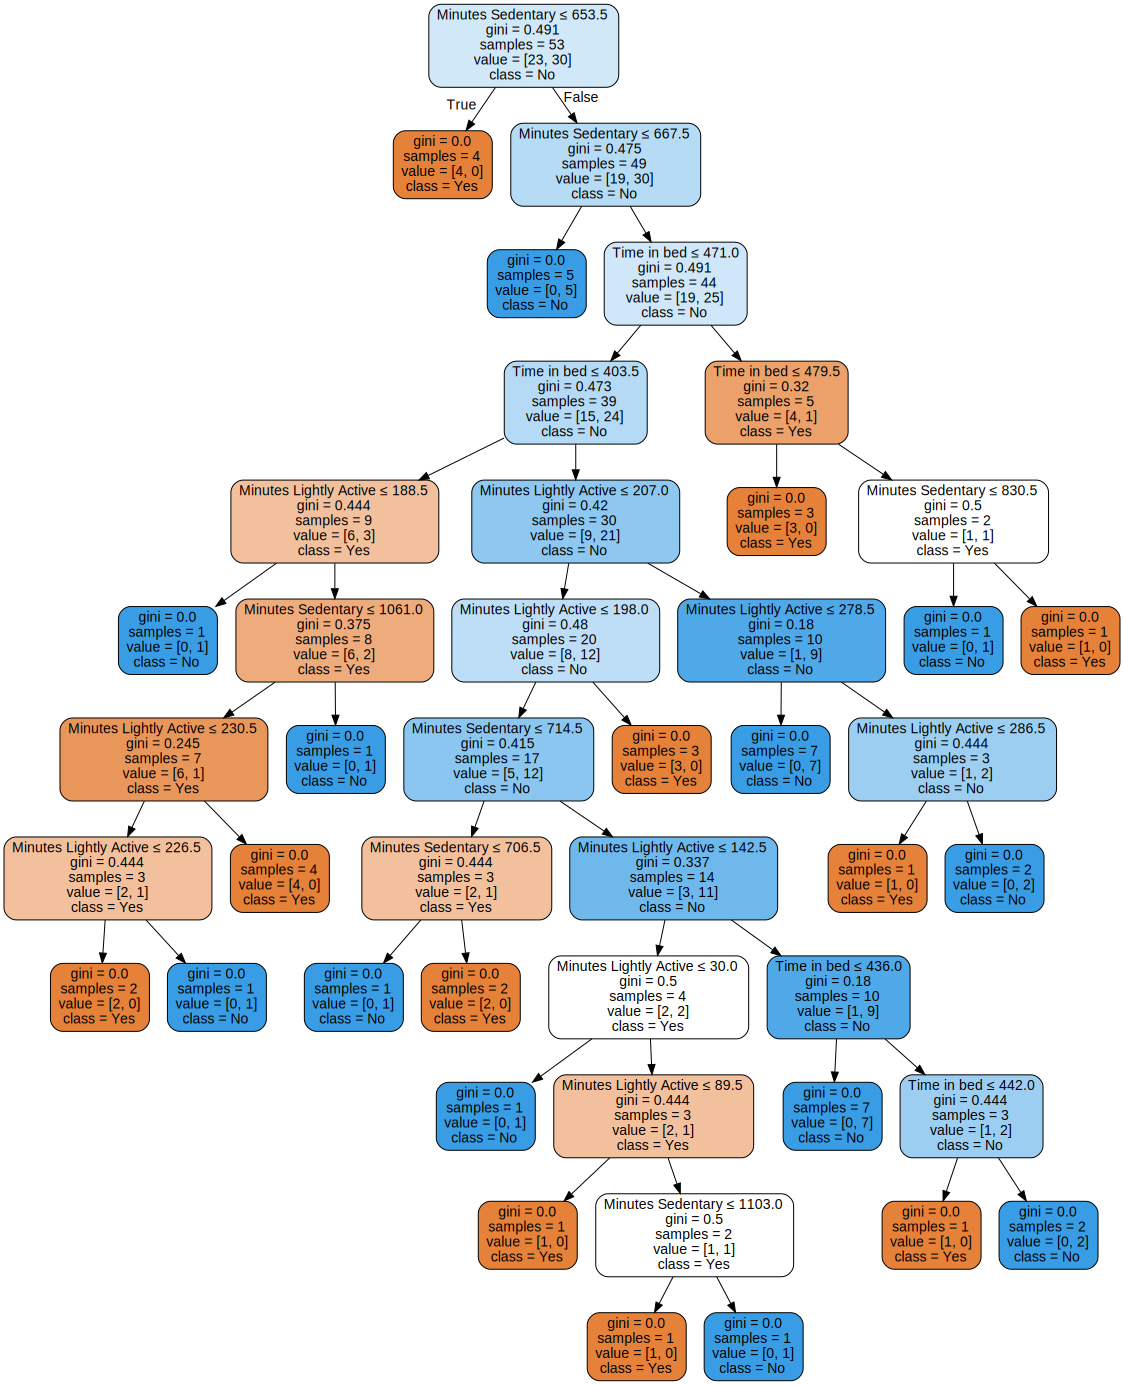

In [69]:
clf_gini_default = DecisionTreeClassifier(criterion = "gini")
trainAndPredict(clf_gini_default)
plotGraph(clf_gini_default)

Dans l'arbre de décision, chaque nœud interne a une règle de décision qui divise les données. Gini appelé Gini ratio, qui mesure l'impureté du nœud. Vous pouvez dire qu'un nœud est pur lorsque tous ses enregistrements appartiennent à la même classe, ces nœuds connus sous le nom de nœud feuille.

Ici, l'arbre résultant n'est pas élagué. Cet arbre non élagué est inexplicable et difficile à comprendre. Dans la section suivante, optimisons-le par élagage.

Accuracy :  47.82608695652174
Report :                precision    recall  f1-score   support

       False       0.50      0.33      0.40        12
        True       0.47      0.64      0.54        11

    accuracy                           0.48        23
   macro avg       0.48      0.48      0.47        23
weighted avg       0.48      0.48      0.47        23



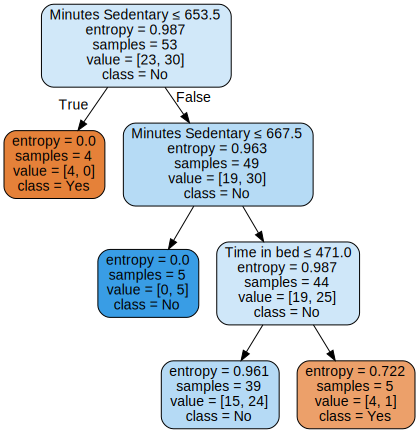

In [70]:
clf_entrp = DecisionTreeClassifier(criterion="entropy", max_depth=3)
trainAndPredict(clf_entrp)
plotGraph(clf_entrp)